# Info 

Author: Xiaoqian Sun <br>
Created: 09/18/2024 <br>
Function: convert spike train to fluorescence, then to calcium traces 

In [56]:
import os 
import time
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import Functions
import simuParams
import simulation 
import importlib;importlib.reload(Functions);importlib.reload(simuParams);importlib.reload(simulation)
from Functions import *
from simuParams import simuParams
from simulation import Simulation


import warnings
warnings.filterwarnings('ignore')

root_path = os.getcwd()
data_path = os.path.join(root_path, 'spkTrain_2_ca2Traces')
result_path = data_path

# Read in data

In [41]:
# parameters
#------------------------------------------------------------------------------------------------
T = 100
dt = 0.01
Lt = int(T/dt)
range_t = np.arange(0, T, dt)

spkTrain_df = pd.read_csv(os.path.join(data_path, 'spkTrain_df.csv')).iloc[:, 1:]
Nt, N = spkTrain_df.shape


# generate spkTimes 
'''
neural network simulation object has spkTimes entry, but it takes a little bit effort to remove any 0s at the end of the spkTimes array
becuase certain spikes can happen at time 0. We'll just process spkTimes here
'''
spkTimes_list = []
spkTrain_list = []
for i in range(N):
    t_sp = np.where(spkTrain_df.iloc[:,i] > 0.5)[0]
    spkTimes_list.append(t_sp*dt)
    spkTrain_list.append(spkTrain_df.iloc[:,i].values)


# Fluorescence simulation 
**this simulation is to model calcium**

In [57]:
# parameters
opts_dict = {'doVectorized': True, 'samplingRate': 1/dt, 
             'ifAssignSpk': True, 'spkTimes':spkTimes_list, 'spkTrain':spkTrain_list,
             
             'A1':np.array([8]*N), 'A2': np.array([0]*N),
             'tau1': np.array([0.5]*N), 'tau2': np.array([1]*N), 'tauOn': np.array([0.01]*N),
             
             'spikeRate': np.array([0.6]*N), 'snr': np.array([5]*N), 'ca_amp': np.array([7100]*N) }

simuPara = simuParams(T, N, **opts_dict)
# test if spike assign was done correctly

print(simuPara.simulation['spkTimes'][0])
print(simuPara.simulation['spkTrain'][0])


ifAssignSpk = True
[ 1.78 16.59 30.34 30.61 34.92 35.76 42.03 43.37 57.06 83.82 85.09 90.25
 92.04]
[0. 0. 0. ... 0. 0. 0.]


In [60]:
# build Simulation Object
#-----------------------------------------------------------------
simuObj = Simulation(params=simuPara)
print('fluorescence has', len(simuObj.x), 'time points')
print('dff has', len(simuObj.xSampled), 'time points')
print('final dff has shape:', simuObj.dff.shape)


fluorescence has 10000 time points
dff has 3000 time points
final dff has shape: (98, 3000)


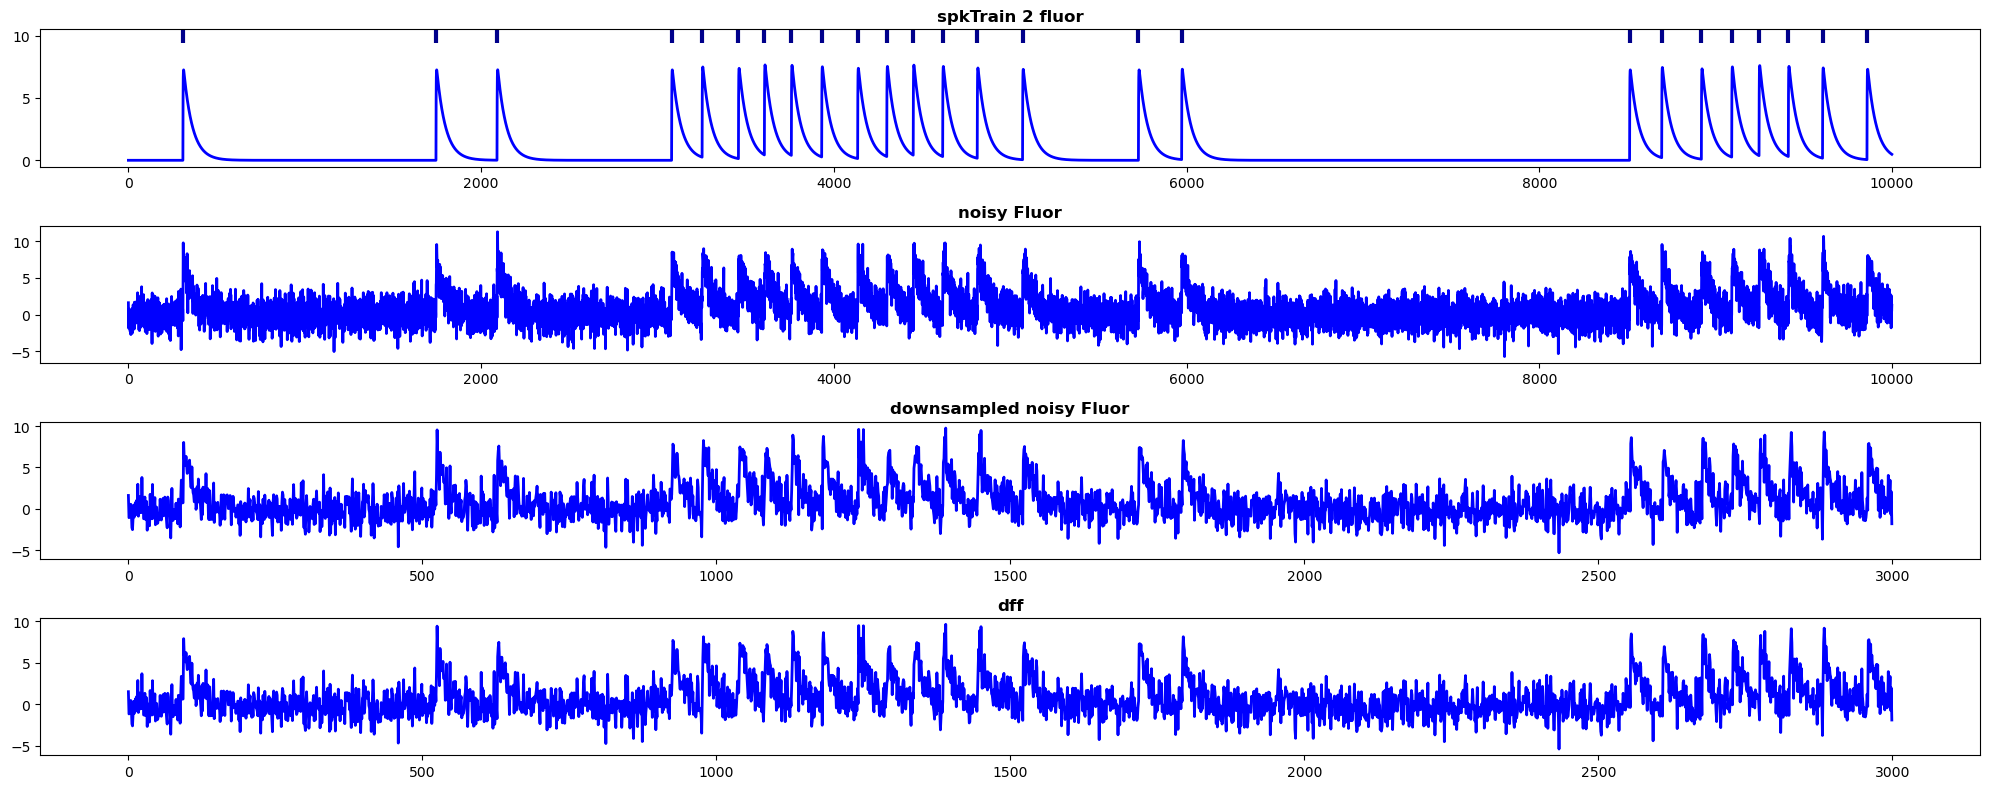

In [89]:
# plot to see
#-----------------------------------------------------------------

nIndex = 1


fig, ax = plt.subplots(4, 1, figsize=(20, 2*4))


ax[0].plot(simuObj.fluor[nIndex, :], c='b', lw=2)
t_sp = np.where(spkTrain_df.iloc[:,nIndex] > 0.5)
ax[0].plot(t_sp, 10*np.ones(len(t_sp)), '|', ms=10, markeredgewidth=3, c='darkblue')
ax[0].set_title('spkTrain 2 fluor', fontweight='bold')

ax[1].plot(simuObj.noisyFluor[nIndex, :], c='b', lw=2)
ax[1].set_title('noisy Fluor', fontweight='bold')

ax[2].plot(simuObj.sampledFluor[nIndex, :], c='b', lw=2)
ax[2].set_title('downsampled noisy Fluor', fontweight='bold')

ax[3].plot(simuObj.dff[nIndex, :], c='b', lw=2)
ax[3].set_title('dff', fontweight='bold')

plt.tight_layout(); plt.savefig(os.path.join(data_path,'fluor_noisy_downsampled_dff')); plt.show()

# save

In [86]:
column_list = spkTrain_df.columns

fluor_df = pd.DataFrame(simuObj.fluor).T
fluor_df.columns = column_list

noisyFluor_df = pd.DataFrame(simuObj.noisyFluor).T
noisyFluor_df.columns = column_list

dff_df = pd.DataFrame(simuObj.dff).T
dff_df.columns = column_list

print('fluor_df.shape:', fluor_df.shape, 'noisyFluor_df.shape:', noisyFluor_df.shape, 'dff_df.shape:', dff_df.shape,)
fluor_df.to_csv(os.path.join(data_path, 'fluor_df.csv'))
noisyFluor_df.to_csv(os.path.join(data_path, 'noisyFluor_df.csv'))
dff_df.to_csv(os.path.join(data_path, 'dff_df.csv'))


dff_df.head(2)

fluor_df.shape: (10000, 98) noisyFluor_df.shape: (10000, 98) dff_df.shape: (3000, 98)


,possionSource1,B0_v_init64_tau_m3_gEE10,B1_v_init64_tau_m3_gEE12,B2_v_init64_tau_m3_gEE14,B3_v_init64_tau_m4_gEE10,B4_v_init64_tau_m4_gEE12,B5_v_init64_tau_m4_gEE14,B6_v_init64_tau_m5_gEE10,B7_v_init64_tau_m5_gEE12,B8_v_init64_tau_m5_gEE14,...,G38_v_init70_tau_m3_gEE14,G39_v_init70_tau_m4_gEE10,G40_v_init70_tau_m4_gEE12,G41_v_init70_tau_m4_gEE14,G42_v_init70_tau_m5_gEE10,G43_v_init70_tau_m5_gEE12,G44_v_init70_tau_m5_gEE14,G45_v_init70_tau_m6_gEE10,G46_v_init70_tau_m6_gEE12,G47_v_init70_tau_m6_gEE14
0,1.964683,1.514424,-0.957072,2.193377,-0.388111,1.528686,-1.897447,0.271688,-2.782565,-1.232190,...,-0.041611,-0.020926,-2.083130,0.766359,0.060836,2.056752,1.386514,0.584900,-1.726385,-0.805216
1,0.346749,-1.163893,-1.166662,-0.717470,-1.689585,-0.056362,2.084364,-0.950530,-1.994094,-0.861899,...,-0.112063,0.654890,-0.736544,0.911032,1.446528,3.222229,0.734756,-3.194457,2.440570,0.726167


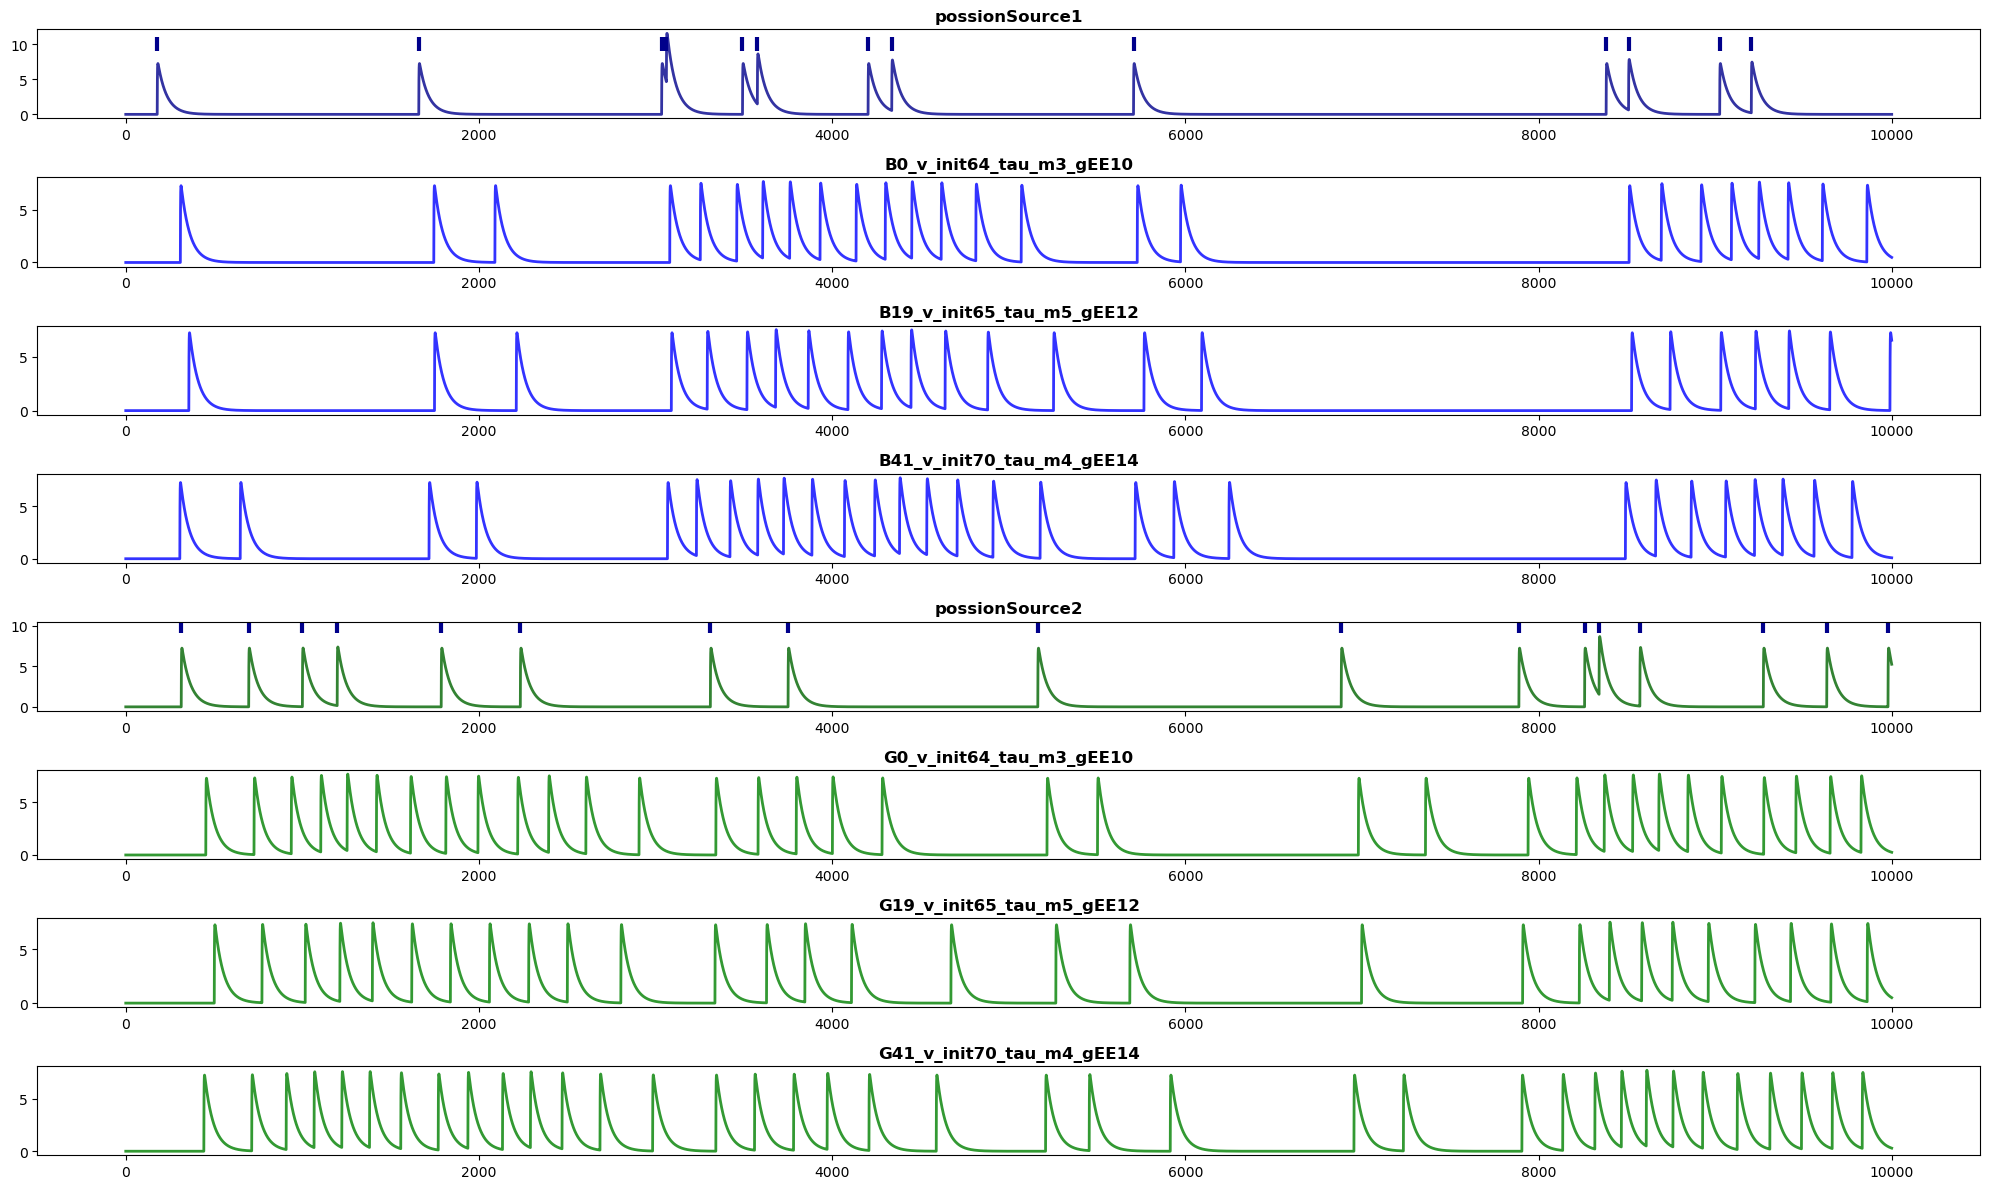

In [87]:
# plot 

# plot a few and get a sense
fig, ax = plt.subplots(8, 1, figsize=(20, 2*6))

ax[0].plot(fluor_df.iloc[:, 0], lw=2, alpha=0.8, c='darkblue')
t_sp = np.where(spkTrain_df.iloc[:,0] > 0.5)
ax[0].plot(t_sp, 10*np.ones(len(t_sp)), '|', ms=10, markeredgewidth=3, c='darkblue')
ax[0].set_title(column_list[0], fontweight='bold')

axIdx = 1; neuronIdx = [1, 20, 42]
for idx in neuronIdx:
    ax[axIdx].plot(fluor_df.iloc[:, idx], c='blue', lw=2, alpha=0.8)
    ax[axIdx].set_title(column_list[idx], fontweight='bold')
    axIdx+=1



ax[axIdx].plot(fluor_df.iloc[:, 49], lw=2, alpha=0.8, c='darkgreen')
t_sp = np.where(spkTrain_df.iloc[:,49] > 0.5)
ax[axIdx].plot(t_sp, 10*np.ones(len(t_sp)), '|', ms=10, markeredgewidth=3, c='darkblue')
ax[axIdx].set_title(column_list[49], fontweight='bold')
axIdx+=1

for idx in neuronIdx:
    ax[axIdx].plot(fluor_df.iloc[:, idx+49], c='g', lw=2, alpha=0.8)
    ax[axIdx].set_title(column_list[idx+49], fontweight='bold')

    axIdx+=1


plt.tight_layout(); plt.savefig(os.path.join(data_path,'sampleNeurons_cleanFluor')); plt.show()

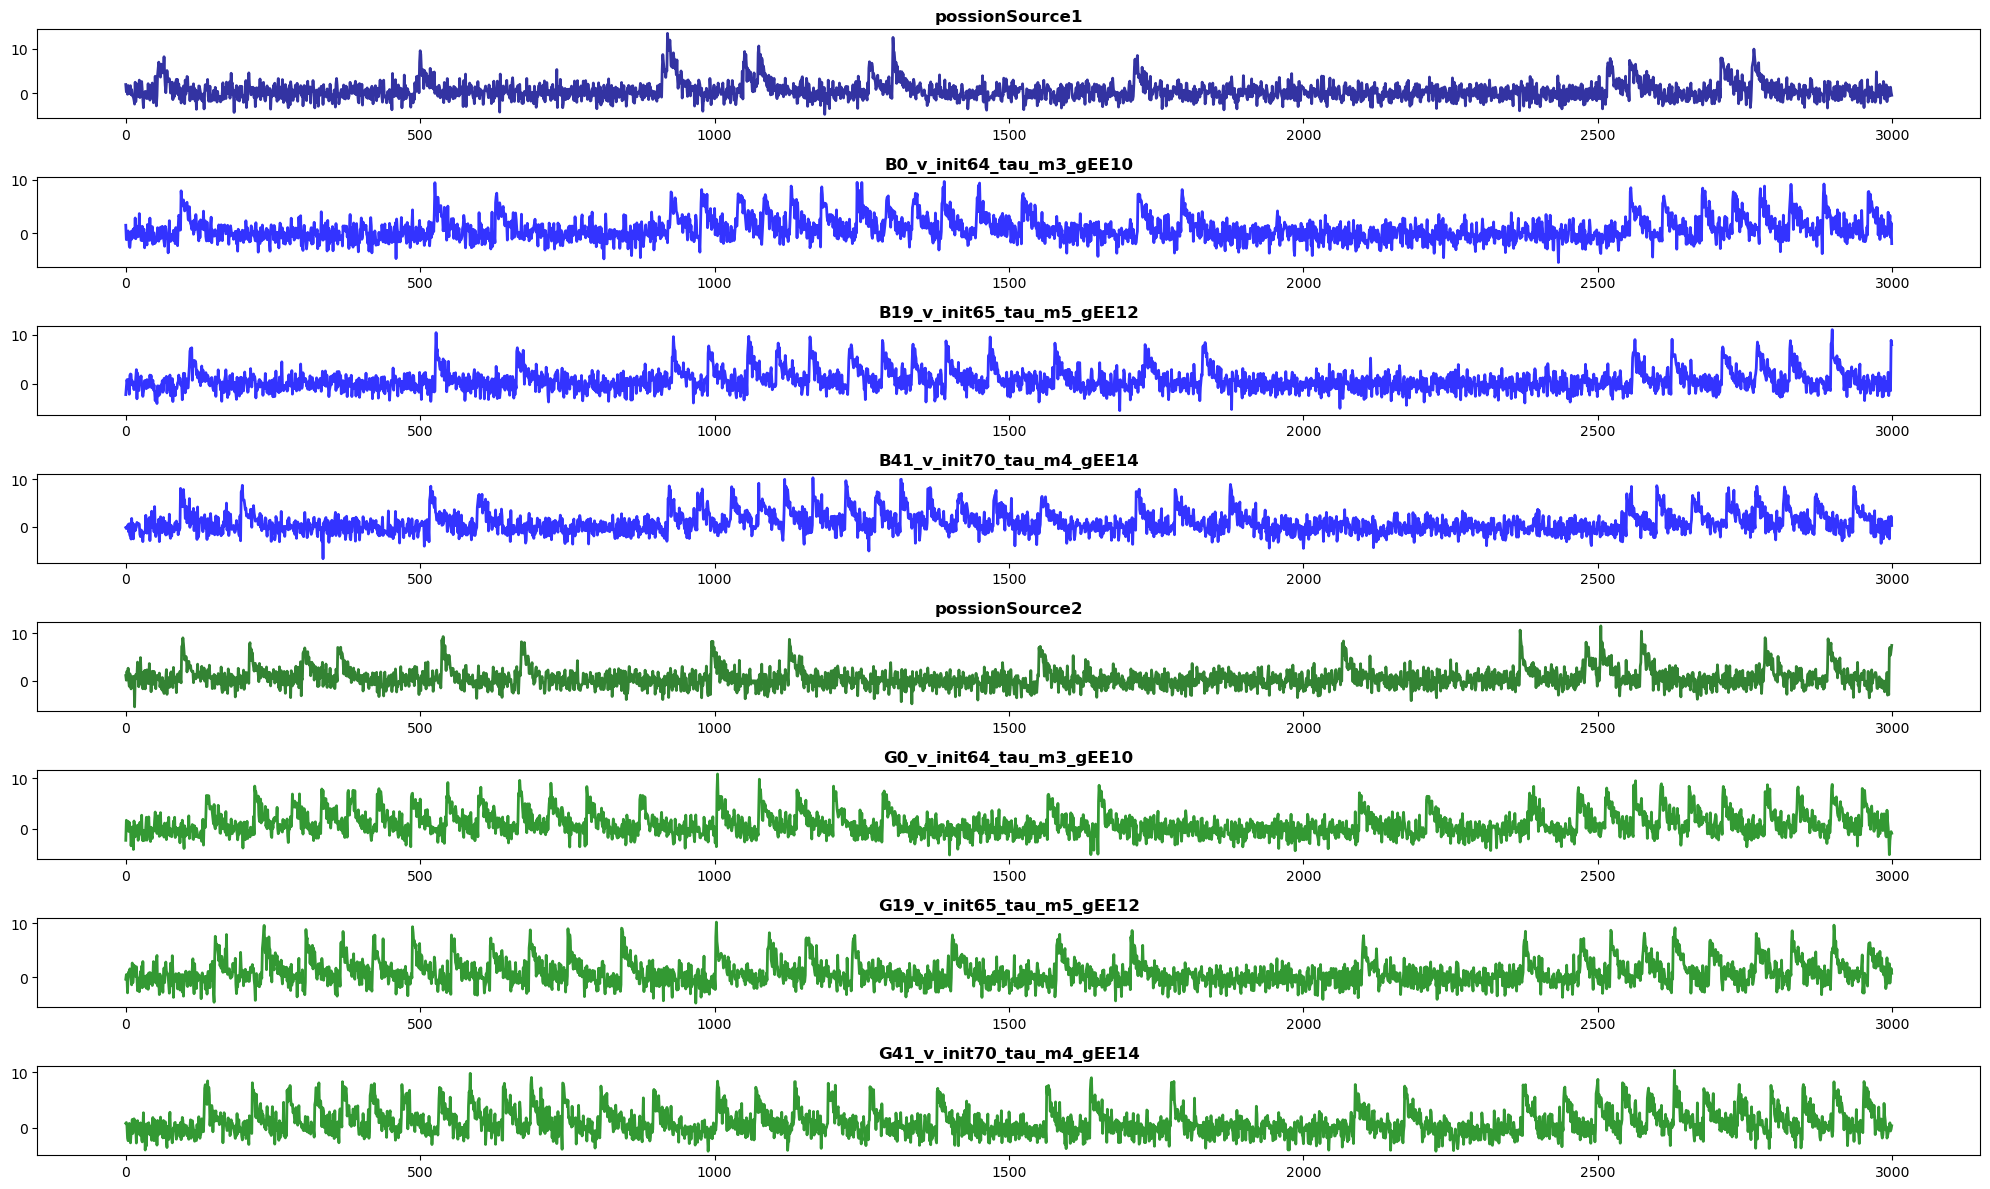

In [88]:
# plot 

# plot a few and get a sense
fig, ax = plt.subplots(8, 1, figsize=(20, 2*6))

ax[0].plot(dff_df.iloc[:, 0], lw=2, alpha=0.8, c='darkblue')
ax[0].set_title(column_list[0], fontweight='bold')

axIdx = 1; neuronIdx = [1, 20, 42]
for idx in neuronIdx:
    ax[axIdx].plot(dff_df.iloc[:, idx], c='blue', lw=2, alpha=0.8)
    ax[axIdx].set_title(column_list[idx], fontweight='bold')
    axIdx+=1



ax[axIdx].plot(dff_df.iloc[:, 49], lw=2, alpha=0.8, c='darkgreen')
ax[axIdx].set_title(column_list[49], fontweight='bold')
axIdx+=1

for idx in neuronIdx:
    ax[axIdx].plot(dff_df.iloc[:, idx+49], c='g', lw=2, alpha=0.8)
    ax[axIdx].set_title(column_list[idx+49], fontweight='bold')

    axIdx+=1


plt.tight_layout(); plt.savefig(os.path.join(data_path,'sampleNeurons_dff'));plt.show()